# Exploratory Analysis on IoT-LAB


We analyse a dataset that was generated collecting 2000 pings on 7 A8-nodes running an RPL instance. We start our analysis importing relevant informations from each node.

In [382]:
from matplotlib import pyplot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

nodes = {} # <a8_node, [time in ms for each icmp message]>
ips = {}  # <a8_node, IP6>
icmp = [n for n in range(1,2001)]   # Produce a sequence of ICMP numbers

for file in os.listdir("traces"):
    if file.split('.')[0].isdigit():
        with open('traces/' + file, 'r') as f:
            lines = f.read().split('\n')
            node = 'A8-'+ file.split('.')[0]
            
            for line in lines:
                line = line.split()
                if len(line) <= 1:
                    continue
                    
                # Import IPs
                if line[0] == 'ping6':
                    ip = line[2].split('ping6')[0][:29]
                    if file not in ips:
                        ips[node] = ip
                elif line[0] == '>' and line[1] == 'ping6':
                    ip = line[3].split('ping6')[0][:29]
                    if file not in ips:
                        ips[node] = ip
                        
                        
                # Import all data
                if line[0] == '12':
                    if node not in nodes:
                        nodes[node] = [float(line[-2])]
                    else:
                        nodes[node].append(float(line[-2]))
                elif line[0] == 'ping' and line[1] == 'timeout':
                    if node not in nodes:
                        nodes[node] = [None]
                    else:
                        nodes[node].append(None)
                    
nodes = pd.DataFrame(nodes) 
nodes = nodes[sorted(nodes.columns.tolist())]
nodes.head(10)

,A8-156,A8-163,A8-173,A8-183,A8-193,A8-204
0,7.536,NaN,12.267,NaN,28.567,NaN
1,8.490,20.823,11.627,33.983,0.648,NaN
2,10.090,15.458,14.822,43.245,0.648,NaN
3,10.730,11.053,13.221,55.357,0.650,NaN
4,9.450,32.374,13.861,NaN,0.648,NaN
5,9.136,17.303,NaN,NaN,42.306,NaN
6,8.811,14.498,10.672,31.147,0.648,NaN
7,8.177,19.863,10.990,21.627,0.648,NaN
8,8.811,16.098,7.858,38.739,0.648,NaN
9,9.770,9.453,8.818,NaN,0.648,NaN


Each node communicates with the root of the DODAG through a certain number of hops. The network was configured in order to have three nodes communicating directly with the root, two node at distance 2 and just one node that was at distance 3 from node 'A8-149'.

In [383]:
hops = {1: ['A8-156','A8-163','A8-173'],\
       2: ['A8-183','A8-193'],\
       3: ['A8-204']}


# Contain mean time for each distance from the root
hop_nodes = pd.DataFrame({1: nodes[hops[1]].mean(axis=1), 2: nodes[hops[2]].mean(axis=1),\
                           3: nodes[hops[3]].mean(axis=1)})
hop_nodes.head(10)

,1,2,3
0,9.901500,28.5670,NaN
1,13.646667,17.3155,NaN
2,13.456667,21.9465,NaN
3,11.668000,28.0035,NaN
4,18.561667,0.6480,NaN
5,13.219500,42.3060,NaN
6,11.327000,15.8975,NaN
7,13.010000,11.1375,NaN
8,10.922333,19.6935,NaN
9,9.347000,0.6480,NaN


For each node we plot the graph that measures the delay with respect to the number of sequence.

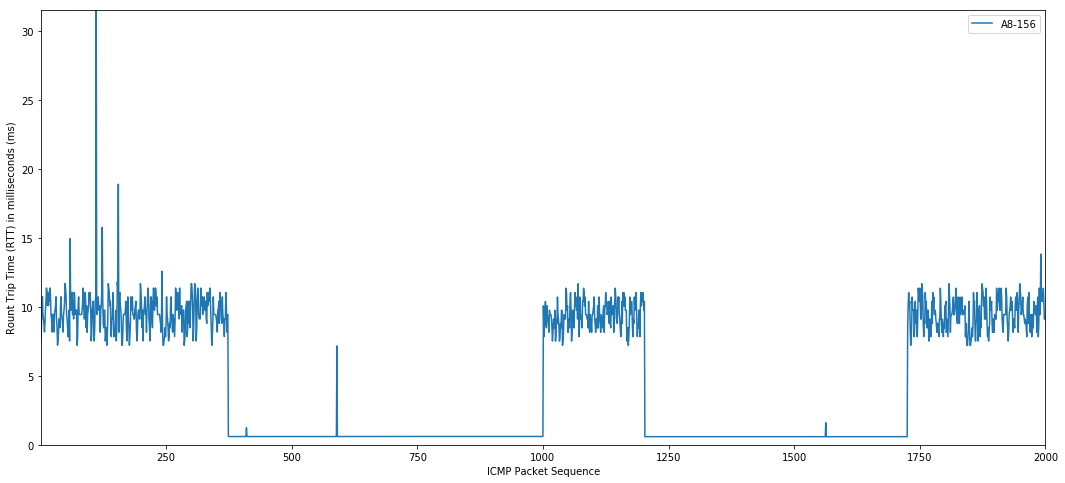

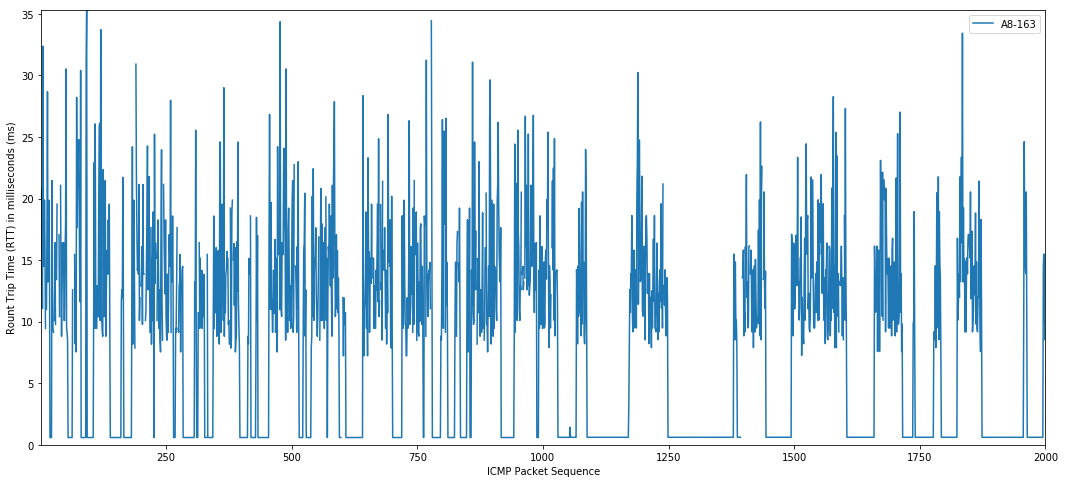

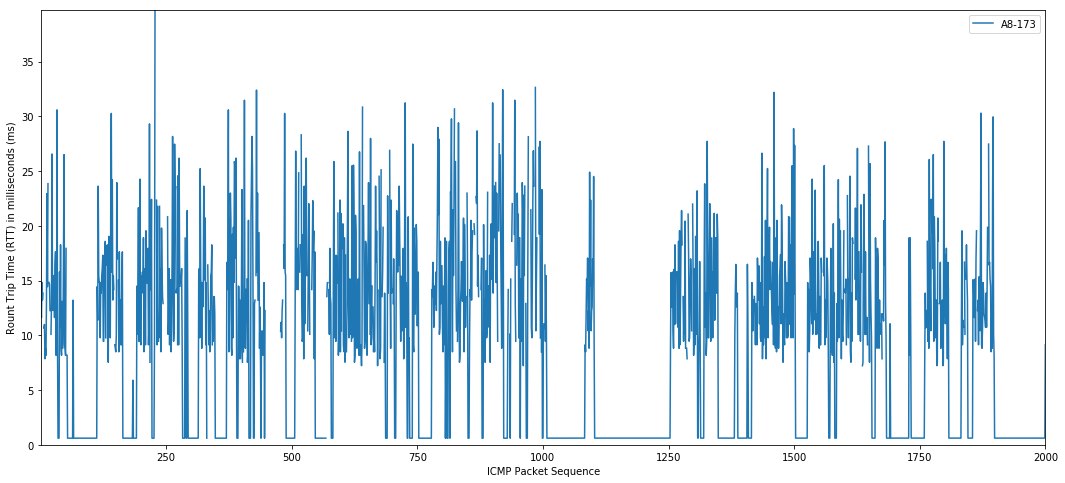

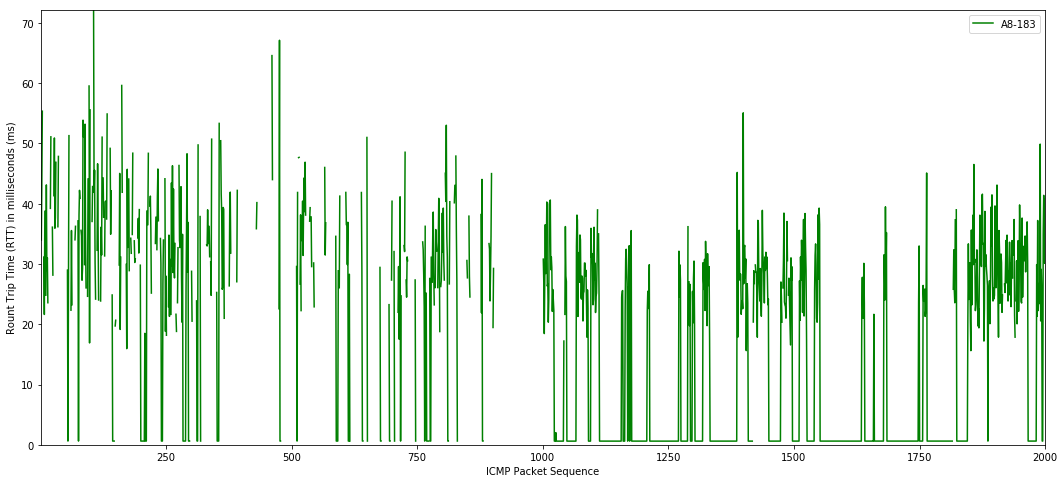

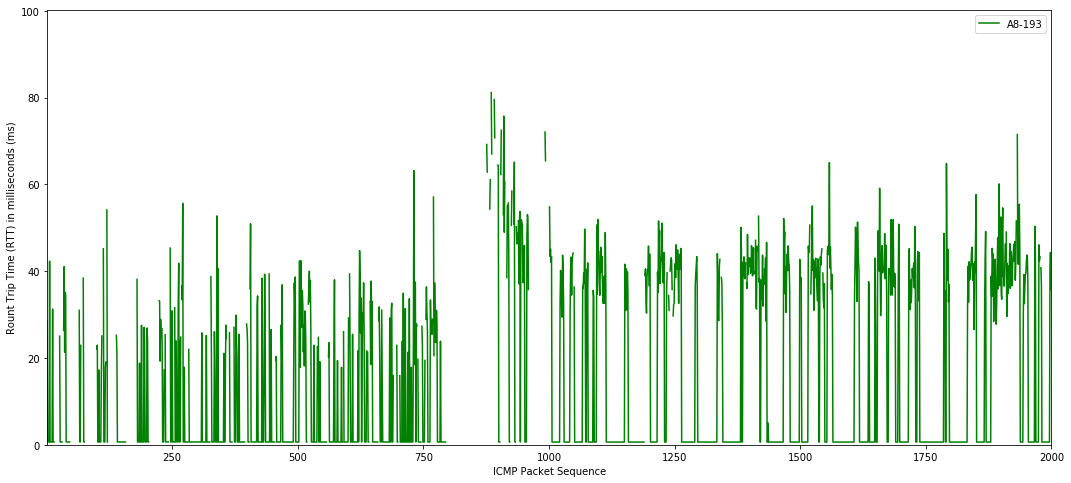

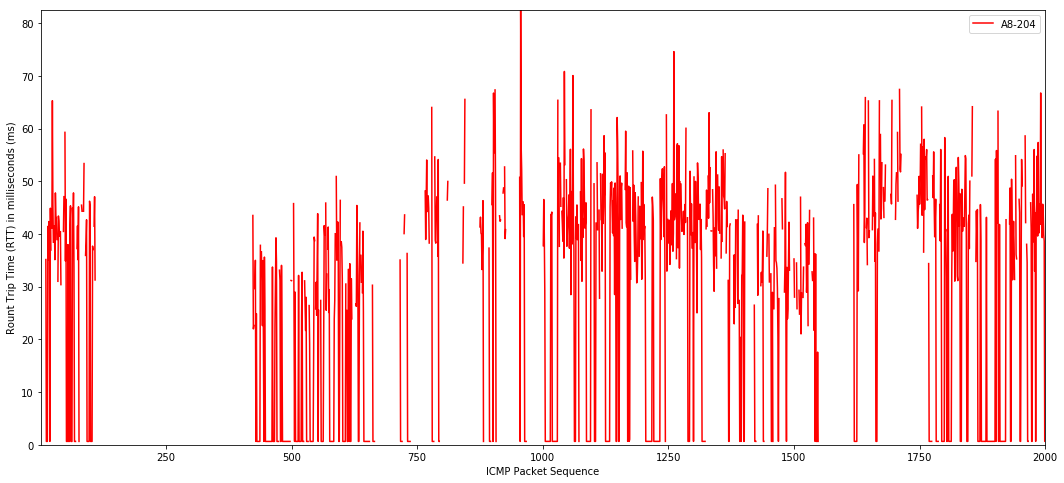

In [384]:
for node in nodes.keys():
    tms = nodes[node]
    
    plt.figure(figsize=(18,8))
    plt.ylabel('Rount Trip Time (RTT) in milliseconds (ms)')
    plt.xlabel('ICMP Packet Sequence')
    
    if node in hops[1]:
        plt.plot(icmp, tms, label=node)
    elif node in hops[2]:
        plt.plot(icmp, tms, 'green', label=node)
    else:
        plt.plot(icmp, tms, 'red', label=node)

    plt.axis([1,icmp[-1], 0.0, tms.max()])
    plt.legend()
    plt.show()

Let us see how does the delay change with respect to the distance from the root.

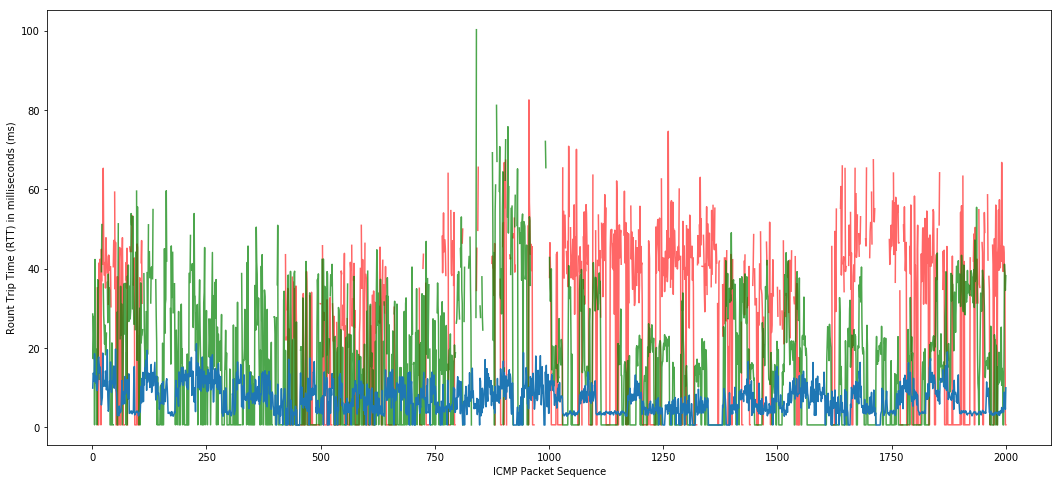

In [385]:
fig, ax = plt.subplots(figsize=(18,8))

line3, = ax.plot(icmp, hop_nodes[3], 'red', alpha=0.6, label='Hop 3')
line2, = ax.plot(icmp, hop_nodes[2], 'green', alpha=0.7, label='Hop 2')
line1, = ax.plot(icmp, hop_nodes[1], label='Hop 1')

plt.ylabel('Rount Trip Time (RTT) in milliseconds (ms)')
plt.xlabel('ICMP Packet Sequence')

plt.show()

It is also useful to read some statistics from the dataset. For each node:

In [386]:
nodes.describe()

,A8-156,A8-163,A8-173,A8-183,A8-193,A8-204
count,1999.000000,1938.000000,1865.000000,1418.000000,1679.000000,1122.000000
mean,4.396073,8.012221,8.766598,16.710147,15.183696,27.714703
std,4.509198,7.781457,8.265416,16.698406,19.440509,21.226565
min,0.588000,0.588000,0.605000,0.609000,0.630000,0.640000
25%,0.589000,0.610000,0.611000,0.615000,0.630000,0.651000
50%,0.605000,8.816000,9.132000,19.715500,0.648000,35.221500
75%,9.129000,13.892000,14.819000,30.536250,35.408500,44.114750
max,31.525000,35.319000,39.722000,72.160000,100.208000,82.513000


For each hop:

In [387]:
hop_nodes.describe()

,1,2,3
count,2000.000000,1838.000000,1122.000000
mean,6.981997,16.321739,27.714703
std,3.852109,15.476964,21.226565
min,0.594000,0.609000,0.640000
25%,3.766333,0.636625,0.651000
50%,6.506000,15.717750,35.221500
75%,9.654667,27.067250,44.114750
max,21.077333,100.208000,82.513000


Now we use a Kernel density estimation (a way to estimate the probability density function of a random variable in a non-parametric way). It is useful to plot also a histogram in order to study the distribution of data.

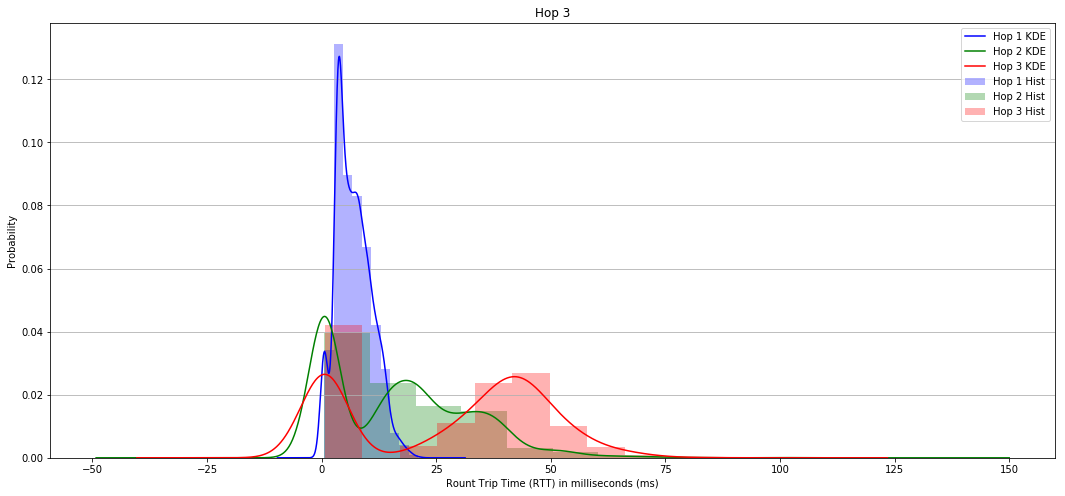

In [388]:
fig, ax = plt.subplots(figsize=(18,8))
for hop in hop_nodes:
    
    if hop == 1:
        hop_nodes[hop].plot.kde(ax=ax,color='blue', title='Hop ' + str(hop), label='Hop 1 KDE')
        hop_nodes[hop].plot.hist(density=True,color='blue',alpha=0.3, ax=ax, label='Hop 1 Hist')
    elif hop == 2:
        hop_nodes[hop].plot.kde(ax=ax,color='green', title='Hop ' + str(hop), label='Hop 2 KDE')
        hop_nodes[hop].plot.hist(density=True,color='green',alpha=0.3, ax=ax, label='Hop 2 Hist')
    else:
        hop_nodes[hop].plot.kde(ax=ax,color='red', title='Hop ' + str(hop), label='Hop 3 KDE')
        hop_nodes[hop].plot.hist(density=True,color='red',alpha=0.3, ax=ax, label='Hop 3 Hist')
        
ax.set_ylabel('Probability')
ax.set_xlabel('Rount Trip Time (RTT) in milliseconds (ms)')
ax.grid(axis='y')
ax.legend()
plt.show()

As you can see, it seems that nodes communicating directly with the root have lower probability of timeouts, while the stability of messages degrades as we move away. Thus, the probability of having a timeout seems to increase as the distance from root increases. Let's check.

In [389]:
pd.DataFrame([[h, str((len(hop_nodes[h]) - hop_nodes[h].count())/len(hop_nodes[h])*100) +'%'] for h in hops], \
             columns=['Hop','Probability of Error'])

,Hop,Probability of Error
0,1,0.0%
1,2,8.1%
2,3,43.9%


It is also interesting to see how the time to complete 2000 pings varies as the distance from the root increases.

In [390]:
time_nodes = {}
for h in hops:
    for time in hop_nodes[h].keys():
        if h not in time_nodes:
            if np.isnan(hop_nodes[h][time]):
                time_nodes[h] = [None]
            else:
                time_nodes[h] = [hop_nodes[h][time]]
        else:
            if np.isnan(hop_nodes[h][time]):
                time_nodes[h].append(None)    
            elif len(list(filter(None, time_nodes[h]))) == 0:
                # time_nodes[h] contains only None values
                time_nodes[h].append(hop_nodes[h][time])
            else:
                time_nodes[h].append(max(filter(None, time_nodes[h])) + hop_nodes[h][time])

time_nodes = pd.DataFrame(time_nodes)
time_nodes.tail(1)

,1,2,3
1999,13963.994833,29999.356,31095.897


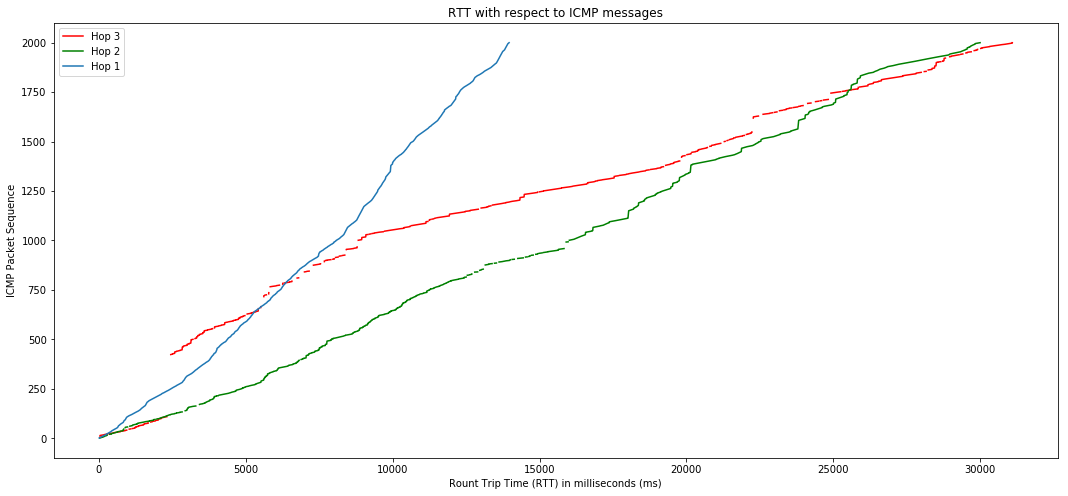

In [391]:
fig, ax = plt.subplots(figsize=(18,8))

line3, = ax.plot(time_nodes[3], icmp, 'red', label='Hop 3')
line2, = ax.plot(time_nodes[2], icmp, 'green', label='Hop 2')
line1, = ax.plot(time_nodes[1], icmp, label='Hop 1')

plt.ylabel('ICMP Packet Sequence')
plt.xlabel('Rount Trip Time (RTT) in milliseconds (ms)')
plt.title('RTT with respect to ICMP messages')
ax.legend()
plt.show()

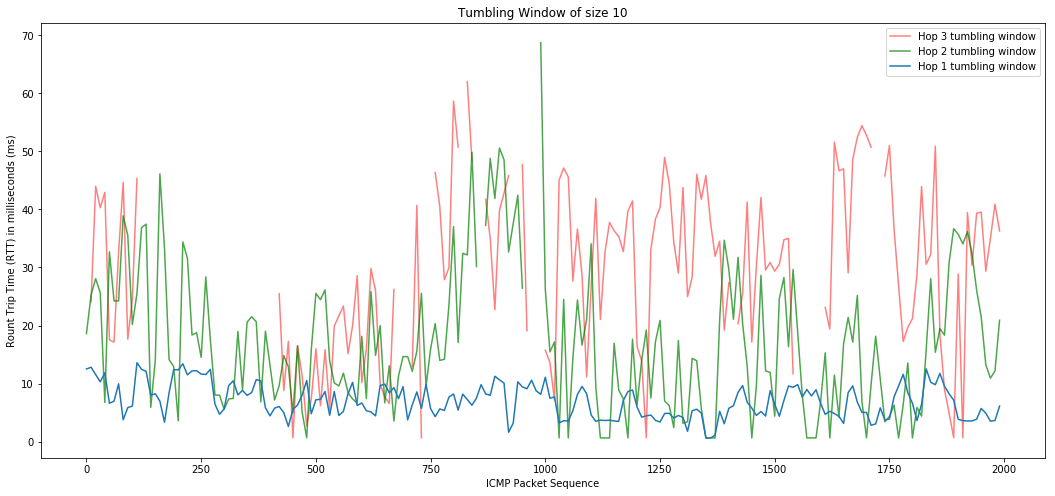

In [392]:
plt.figure(figsize=(18,8))
plt.ylabel('Rount Trip Time (RTT) in milliseconds (ms)')
plt.xlabel('ICMP Packet Sequence')
plt.plot(hop_nodes[3].groupby(hop_nodes[3].index // 10 * 10).mean(), 'red', alpha=0.5, label='Hop 3 tumbling window')
plt.plot(hop_nodes[2].groupby(hop_nodes[2].index // 10 * 10).mean(), 'green', alpha=0.7, label='Hop 2 tumbling window')
plt.plot(hop_nodes[1].groupby(hop_nodes[1].index // 10 * 10).mean(), label='Hop 1 tumbling window')
plt.title('Tumbling Window of size 10')
plt.legend()

Let us try to exclude outliers from this plot.

In [393]:
std_values = pd.DataFrame(columns=[1,2,3])  # Maintain x(t) if mean-2*std <= x(t) <? mean+2*std
outliers = pd.DataFrame(columns=[1,2,3])    # Maintain x(t) otherwise

for h in hops:
    mn = hop_nodes[h].mean()
    std =hop_nodes[h].std()
    std_window = pd.Series([])  # Standard values
    out_window = pd.Series([])  # Outliers

    for window in (hop_nodes[h].groupby(hop_nodes[h].index // 10 * 10)):
        std_curr = []
        out_curr = []
        for x in window[1]:
            if mn-2*std <= x and x <= mn+2*std:
                std_curr.append(x)
                out_curr.append(None)
            else:
                std_curr.append(None)
                out_curr.append(x)
        
        std_window = std_window.append(pd.Series(std_curr))
        out_window = out_window.append(pd.Series(out_curr))
    
    std_values[h] = std_window
    outliers[h] = out_window

std_values = std_values.reset_index().drop(columns=['index'])
std_values.fillna(value=pd.np.nan, inplace=True)
outliers = outliers.reset_index().drop(columns=['index'])
outliers.fillna(value=pd.np.nan, inplace=True)

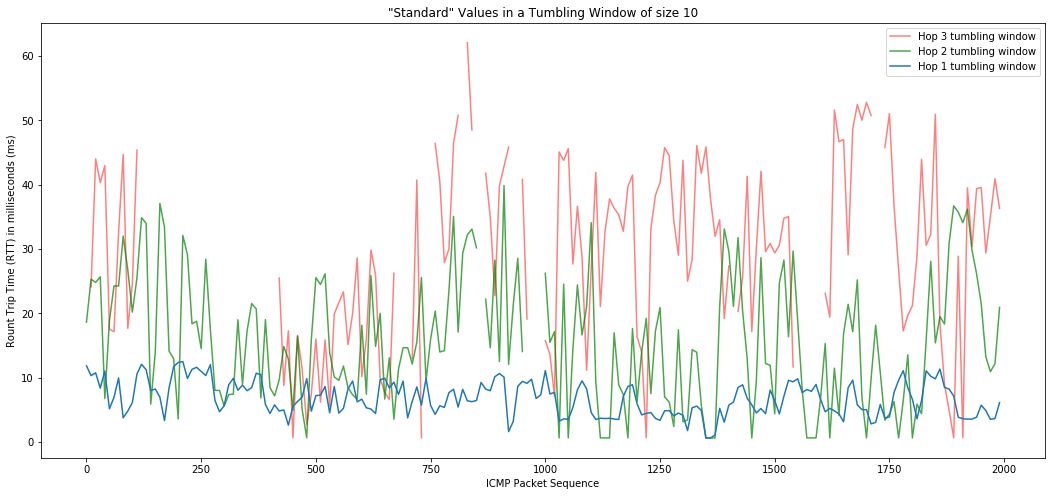

In [394]:
plt.figure(figsize=(18,8))
plt.ylabel('Rount Trip Time (RTT) in milliseconds (ms)')
plt.xlabel('ICMP Packet Sequence')
plt.plot(std_values[3].groupby(std_values[3].index // 10 * 10).mean(), 'red', alpha=0.5, label='Hop 3 tumbling window')
plt.plot(std_values[2].groupby(std_values[2].index // 10 * 10).mean(), 'green', alpha=0.7, label='Hop 2 tumbling window')
plt.plot(std_values[1].groupby(std_values[1].index // 10 * 10).mean(), label='Hop 1 tumbling window')
plt.title('"Standard" Values in a Tumbling Window of size 10')
plt.legend()

It would be useful also to plot the distributions of the standard values and that of the outliers.

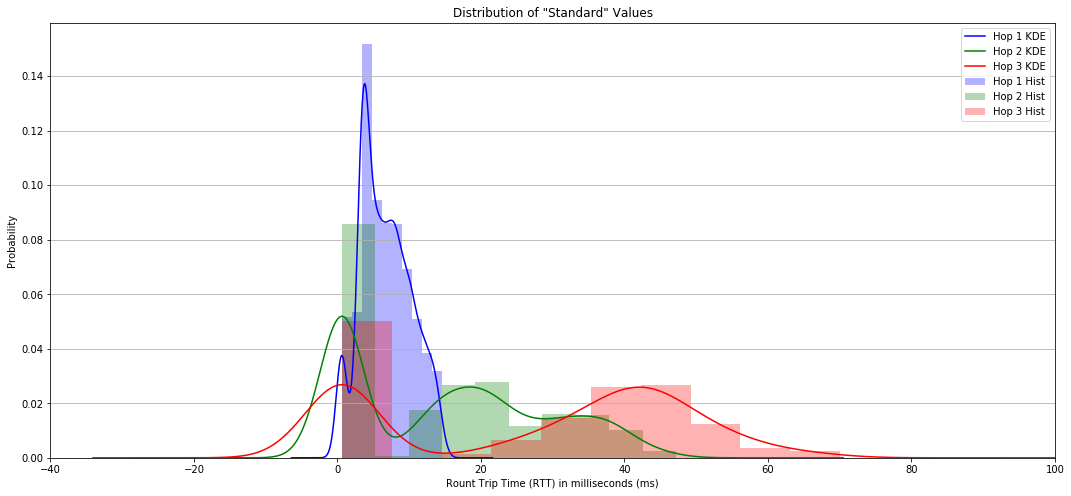

In [395]:
fig, ax = plt.subplots(figsize=(18,8))
for hop in std_values:
    
    if hop == 1:
        std_values[hop].plot.kde(ax=ax,color='blue', label='Hop 1 KDE')
        std_values[hop].plot.hist(density=True,color='blue',alpha=0.3, ax=ax, label='Hop 1 Hist')
    elif hop == 2:
        std_values[hop].plot.kde(ax=ax,color='green', label='Hop 2 KDE')
        std_values[hop].plot.hist(density=True,color='green',alpha=0.3, ax=ax, label='Hop 2 Hist')
    else:
        std_values[hop].plot.kde(ax=ax,color='red', label='Hop 3 KDE')
        std_values[hop].plot.hist(density=True,color='red',alpha=0.3, ax=ax, label='Hop 3 Hist')
        
ax.set_ylabel('Probability')
ax.set_xlabel('Rount Trip Time (RTT) in milliseconds (ms)')
ax.set_title('Distribution of "Standard" Values')
ax.grid(axis='y')
ax.legend()
ax.set_xlim([-40,100])
plt.show()

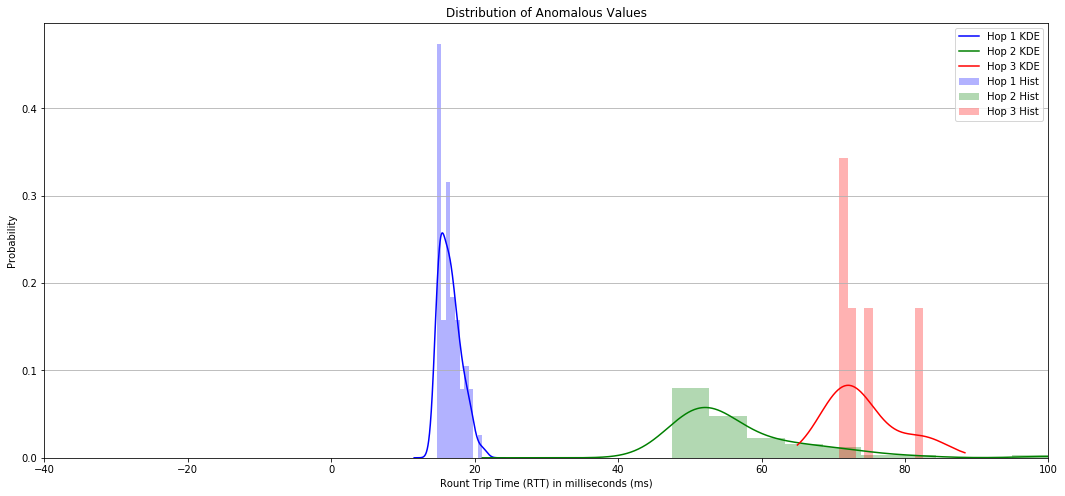

In [396]:
fig, ax = plt.subplots(figsize=(18,8))
for hop in outliers:
    
    if hop == 1:
        outliers[hop].plot.kde(ax=ax,color='blue', label='Hop 1 KDE')
        outliers[hop].plot.hist(density=True,color='blue',alpha=0.3, ax=ax, label='Hop 1 Hist')
    elif hop == 2:
        outliers[hop].plot.kde(ax=ax,color='green', label='Hop 2 KDE')
        outliers[hop].plot.hist(density=True,color='green',alpha=0.3, ax=ax, label='Hop 2 Hist')
    else:
        outliers[hop].plot.kde(ax=ax,color='red', label='Hop 3 KDE')
        outliers[hop].plot.hist(density=True,color='red',alpha=0.3, ax=ax, label='Hop 3 Hist')
        
ax.set_ylabel('Probability')
ax.set_xlabel('Rount Trip Time (RTT) in milliseconds (ms)')
ax.grid(axis='y')
ax.set_title('Distribution of Anomalous Values')
ax.legend()
ax.set_xlim([-40,100])
plt.show()

Let us do the same for packet loss.

In [397]:
lost = pd.DataFrame()  # Maintain x(t) if mean-2*std <= x(t) <? mean+2*std
for h in hop_nodes:
    loss_p = []
    
    for p in hop_nodes[h]:
        if not np.isnan(p):
            loss_p.append(np.nan)
        else:
            loss_p.append(-100)
    
    lost[h] = pd.Series(loss_p)
    
lost.head(10)

,1,2,3
0,NaN,NaN,-100.0
1,NaN,NaN,-100.0
2,NaN,NaN,-100.0
3,NaN,NaN,-100.0
4,NaN,NaN,-100.0
5,NaN,NaN,-100.0
6,NaN,NaN,-100.0
7,NaN,NaN,-100.0
8,NaN,NaN,-100.0
9,NaN,NaN,-100.0


Now we can compare loss with outliers to check if there is some kind of relation.

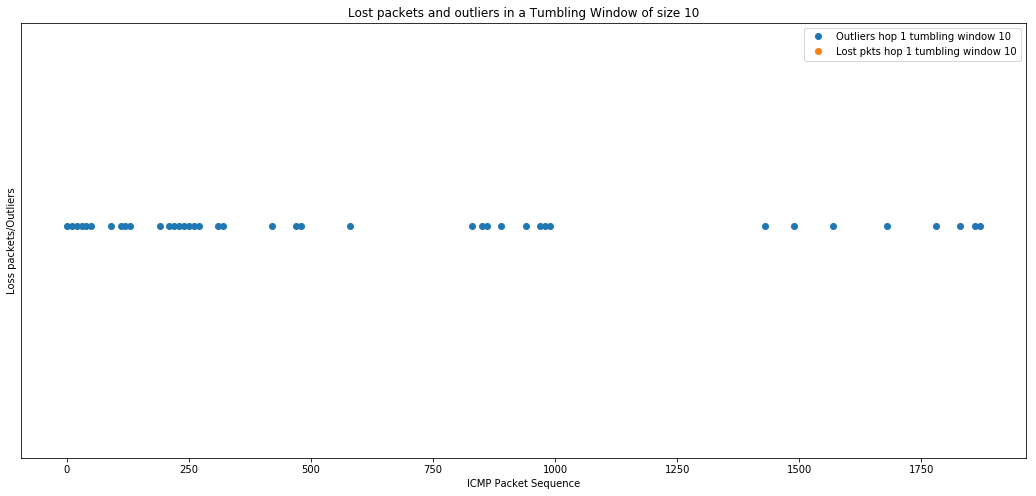

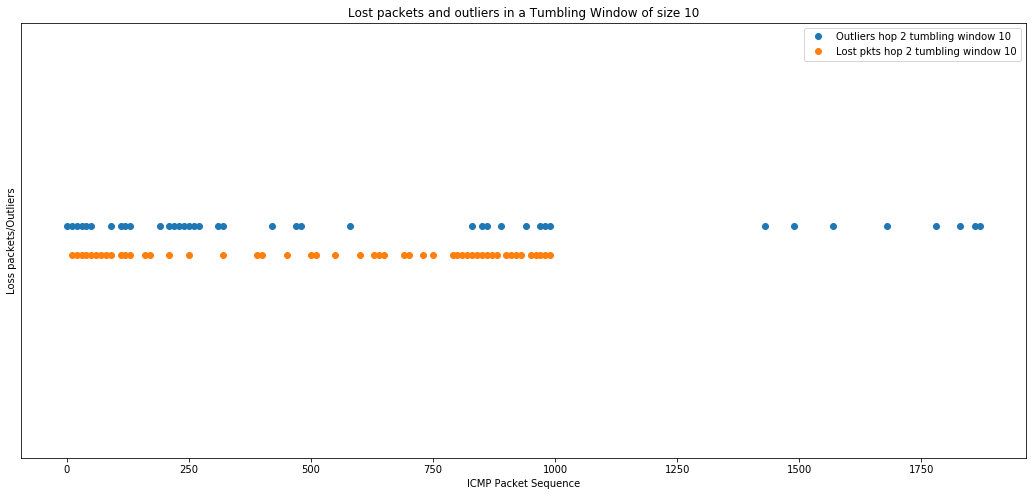

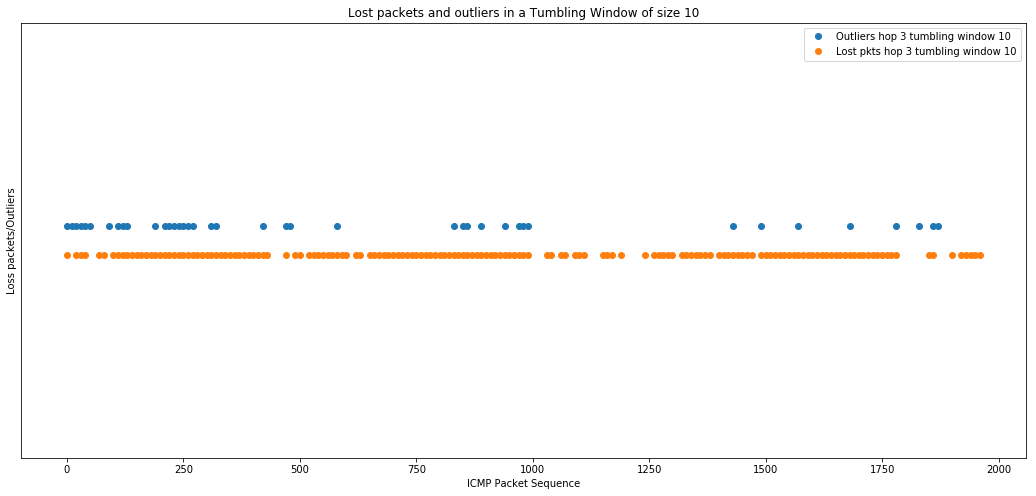

In [398]:
for h in hop_nodes:
    plt.figure(figsize=(18,8))
    plt.ylabel('Loss packets/Outliers')
    plt.xlabel('ICMP Packet Sequence')

    plt.plot(outliers[1].groupby(outliers[1].index // 10 * 10).mean().dropna().index, [1 for x in outliers[1].groupby(outliers[1].index // 10 * 10).mean().dropna().index], 'o', label='Outliers hop '+str(h)+' tumbling window 10')
    plt.plot(lost[h].groupby(lost[h].index // 10 * 10).mean().dropna().index, [-1 for x in lost[h].groupby(lost[h].index // 10 * 10).mean().dropna().index], 'o', label='Lost pkts hop '+str(h)+' tumbling window 10')
    
    plt.title('Lost packets and outliers in a Tumbling Window of size 10')
    plt.ylim([-15,15])
    plt.yticks([])
    plt.legend()